In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
import re
import json

# Realiza una búsqueda en Google y devuelve los resultados
def google_search(driver, palabra_clave, hl="es", gl="mx", num=10):
    # Construir link de búsqueda
    google_search_url = f"https://www.google.com/search?hl={hl}&gl={gl}&num={num}&q="

    # Construir la URL de búsqueda
    search_url = google_search_url + palabra_clave

    # Realizar la búsqueda
    driver.get(search_url)

    # Esperar un poco para que se carguen los resultados
    time.sleep(5)

    # Función que detecta si se muestra un captcha
    def detect_captcha():
        captcha = driver.find_elements(By.XPATH, "//form[@id='captcha-form']")
        if captcha:
            print("Captcha detectado, esperando a que se resuelva...")
            time.sleep(5)
            return detect_captcha()
        return False
    
    # Detectar si se muestra un captcha
    detect_captcha()

    # Obtener el html de la página
    html = driver.page_source

    # Crear un objeto BeautifulSoup
    soup = BeautifulSoup(html, "html.parser")

    # Cantidad de resultados
    result_stats = soup.find("div", id="result-stats")

    # Encontrar los trozos de html que contienen los resultados "MjjYud"
    results = soup.find_all("div", class_="MjjYud")

    if not result_stats:
        print("result_stats =", result_stats)
        
        time.sleep(5)

        # Opciones de Chrome
        chrome_options = Options()
        driver = webdriver.Chrome(executable_path="resource/chromedriver.exe", options=chrome_options)

        return google_search(driver, palabra_clave, hl, gl, num)

    # Diccionario de resultados
    search_results = {
        "result_stats": result_stats.text,
        "results": []
    }
    
    # Para cada resultado, extraer el título, snippet y el href
    for i, result in enumerate(results):
        title_tag = result.find("h3")
        if title_tag:
            title = title_tag.text
        else:
            continue
        snippet_div = result.find("div", class_=re.compile(r"^VwiC3b"))
        snippet = snippet_div.text if snippet_div else "No snippet"
        link_tag = result.find("a")
        href = link_tag["href"] if link_tag else "No link"

        search_results["results"].append({
            "title": title,
            "snippet": snippet,
            "href": href
        })

    return search_results

In [ ]:
# Importar paises.json
with open("paises.json", "r") as file:
    paises = json.load(file)

# Configurar el driver de Chrome
chrome_options = Options()
chrome_options.binary_location = "C:/Program Files/Google/Chrome/Application/chrome.exe" 
executable_path = "resource/chromedriver.exe" 
service = Service(executable_path=executable_path)

In [ ]:
# Lista donde se guardarán los resultados (Correr antes de la busqueda)
Resultados = []

In [ ]:
# Configuración de búsqueda (Modificar según sea necesario)
###############

busqueda = "Corrupcion"
Nombre_Archivo = f"Resultados_{busqueda}.json"

flag = True # Cambia a False para buscar a partir del siguiente país
A_Patir_de = "EspaÃ±a"

###############

driver = webdriver.Chrome(service=service, options=chrome_options)

# Realizar búsquedas
for item in paises:
    if item["country"] == A_Patir_de:
        flag = True
    if flag:
        print("Buscando en:", item["country"])
        search_results = google_search(driver, busqueda, gl=item["gl"], hl=item["hl"], num=100)

        # Solo se añaden resultados
        Resultados.append({
            "country": item["country"],
            "search_results": search_results
        })

# Cerrar el navegador al finalizar
driver.quit()

In [ ]:
# Guardar los resultados en un archivo JSON
with open(Nombre_Archivo, "w") as file:
    json.dump(Resultados, file, indent=4)

In [ ]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"Resultados/Resultados_{busqueda}.json"

with open(Nombre_Archivo, "r") as file:
    resultados = json.load(file)

# Crear matriz de coincidencias de href
coincidencias = {}
for pais in resultados:
    coincidencias[pais["country"]] = {}
    for pais2 in resultados:
        coincidencias[pais["country"]][pais2["country"]] = 0

for pais in resultados:
    for pais2 in resultados:
        for result in pais["search_results"]["results"][:20]:
            for result2 in pais2["search_results"]["results"][:20]:
                if result["href"] == result2["href"]:
                    coincidencias[pais["country"]][pais2["country"]] += 1

In [ ]:
# Guardar los puros hrefs únicos
# para evitar duplicados en el análisis posterior

res_unicos = []

for pais in resultados:
    for result in pais["search_results"]["results"]:
        if result["href"] not in res_unicos:
            res_unicos.append(result["href"])

# Guardar res_unicos en un archivo
# with open("res_unicos_discriminacion.json", "w") as file:
#     json.dump(res_unicos, file, indent=4)

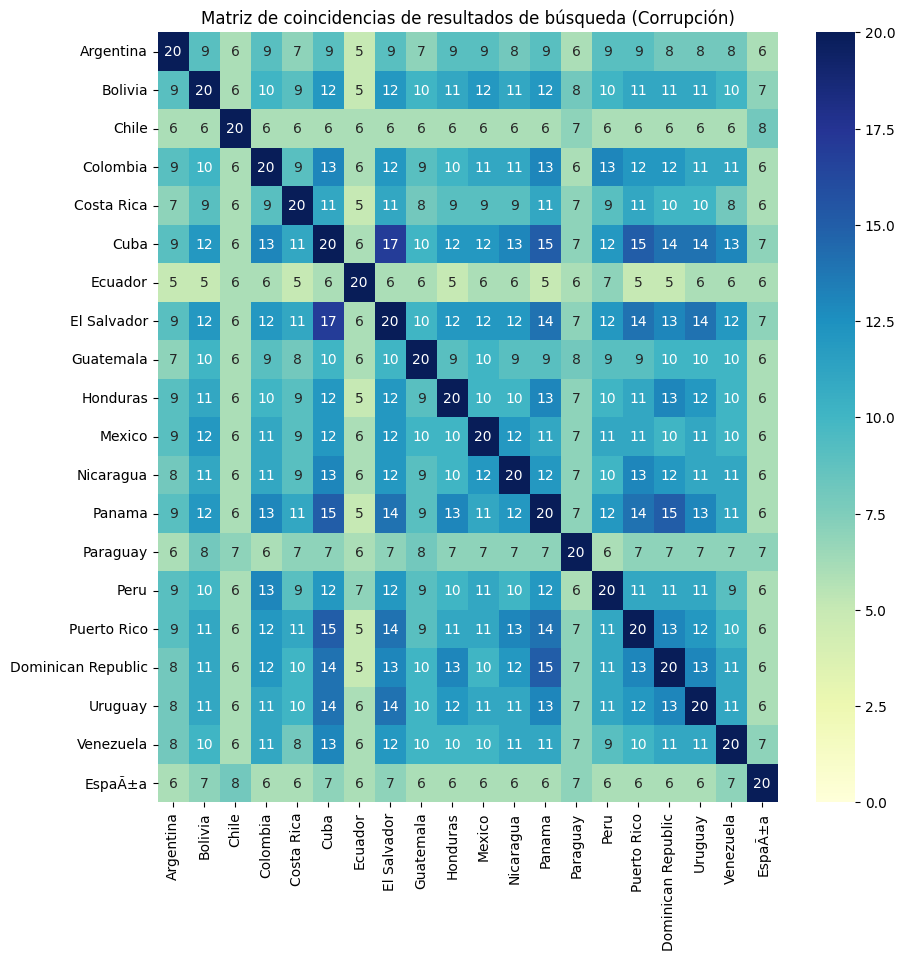

In [ ]:
# Crear heatmap de coincidencias
import seaborn as sns
import matplotlib.pyplot as plt

# Crear matriz de coincidencias
matriz = []
for pais in coincidencias:
    matriz.append([coincidencias[pais][pais2] for pais2 in coincidencias])

# Crear heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(matriz, annot=True, fmt="d", xticklabels=coincidencias.keys(), yticklabels=coincidencias.keys(), vmin=0, vmax=20, cmap="YlGnBu")
plt.title("Matriz de coincidencias de resultados de búsqueda (Corrupción)")

# Guardar heatmap
# plt.savefig("Coincidencias/heatmap_violencia.png")

plt.show()